# Training feature selection and Random Forest classifier training

## Background

This notebook focuses on training a Random Forest classifier for wetland mapping and classification using Earth Observation (EO) measurements. Before fitting the classifier, the notebook removes highly correlated features, aiming to optimize the model's performance. Furthermore, it evaluates the model's performance using a confusion matrix, providing insights into the classification accuracy for different wetland classes. By incorporating these steps, the notebook aims to enhance the accuracy, interpretability, and reliability of the Random Forest classifier in mapping and classifying wetlands.

## Fit and evaluate a Random Forest classifier

We use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) implemented in the [`scikit-learn`](https://scikit-learn.org/stable/) Python libary to map wetland types. 

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

A number of hyperparameters can be tuned for this classifier and we will use funtionalities provided by the [`scikit-learn`](https://scikit-learn.org/stable/) libary to tune and evaluate the model.

This notebook demonstrates how to fit, tune and evaluate the wetland type classification model. We will use the subset of training features balanced and selected earlier in the notebook.

### Load necessary packages

In [1]:
%matplotlib inline
import os
import json
import datacube
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr 
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from joblib import dump

### Load sampled training data
We will load the training data saved from the [feature extraction notebook](03_Feature_Extraction.ipynb).

In [2]:
# Specify a prefix to identify the area of interest in the saved outputs
# By assigning the desired prefix, you can easily identify the outputs associated with the specific area of interest.
prefix = 'Rwanda'

training_features = gpd.read_file(f'results/{prefix}_training_features.geojson')

# Check if both 'class_id_binary' and 'class_id_type' are present
if 'class_id_binary' in training_features.columns and 'class_id_type' in training_features.columns:
    fields = ['class_id_binary', 'class_id_type']
elif 'class_id_binary' in training_features.columns:
    fields = ['class_id_binary']
elif 'class_id_type' in training_features.columns:
    fields = ['class_id_type']
else:
    fields = []

print(fields)


['class_id_binary', 'class_id_type']


Remove unnecessary columns e.g. coordinates and geometry attributes and remove samples with NaN values which were 0 after geomedian calculation:

#### Training features with wetland classes

In [3]:
# drop columns not for analysis
df_training_data=training_features.iloc[:,:-3]
# remove invalid values
# df_training_data=df_training_data.loc[(df_training_data!=0).all(axis=1)].reset_index(drop=True) 
print('Number of features: ',len(df_training_data.columns))

df_training_data.head()

Number of features:  50


,class_id_binary,class_id_type,Annual_blue_0,Annual_green_0,Annual_red_0,Annual_red_edge_1_0,Annual_red_edge_2_0,Annual_red_edge_3_0,Annual_nir_1_0,Annual_nir_2_0,...,slope_500,DTW_FIA_0.25_ha,DTW_FIA_1_ha,profile_curvature_100,twi_100,sent1_vv,sent1_vh,alos_hh,alos_hv,WOfS_annual_frequency
0,1,3.0,408.00,499.00,388.5,435.00,356.5,362.50,316.5,328.00,...,1.354555,0.000000,0.0,0.000000,4.605170,0.007680,0.001296,739.5,333.0,0.85
1,0,0.0,476.00,732.50,976.5,1394.00,1938.5,2145.00,2125.5,2295.00,...,1.534538,0.091001,0.0,934.775269,-1.891730,0.130440,0.031827,4344.5,2095.0,0.00
2,0,0.0,856.50,1075.00,1125.5,1535.50,2382.0,2660.50,2664.0,2915.50,...,1.542351,0.000000,0.0,-410.481415,-2.618634,0.169298,0.033677,6115.0,2391.0,0.00
3,0,0.0,622.75,879.25,974.5,1380.25,2378.5,2741.25,2772.5,3017.75,...,1.444573,0.148893,0.0,650.633972,-2.394608,0.257211,0.045624,9604.5,2825.5,0.00
4,1,2.0,838.50,1407.00,2210.5,2427.50,1730.5,1776.50,1461.5,1231.50,...,1.489965,0.000000,0.0,182.926987,3.430334,0.005980,0.001519,788.5,397.5,1.00


### Check for feature correlation 

When it comes to training feature selection, our approach involved extracting a wide range of Earth Observation (EO) measurements that had the potential to contribute to the mapping and classification of wetlands. However, it is important to address the issue of correlated measurements, where certain features describe similar or related properties of wetlands. Including highly correlated features in a model can increase its complexity without necessarily improving prediction performance. To mitigate this, it is considered good practice to remove highly correlated features. By doing so, we reduce the complexity of the model while maintaining or even enhancing its prediction capabilities.


To inspect the feature correlations, we will split the data into features and labels.

In [4]:
# split into features and labels
X = df_training_data.drop(fields, axis=1).values
y = df_training_data[['class_id_binary']].values.ravel()

#### Create and visualize the correlation_matrix

The correlations can be visualized in a color-coded table. The coefficient values range from 0 to 1, with 0 for no corelation and 1 for perfect correlation. The diagonal elements are always 1.

In [5]:
X_ = df_training_data.drop(fields, axis=1)
correlation_matrix = X_.corr().abs()

# plot correlation matrix
correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,Annual_blue_0,Annual_green_0,Annual_red_0,Annual_red_edge_1_0,Annual_red_edge_2_0,Annual_red_edge_3_0,Annual_nir_1_0,Annual_nir_2_0,Annual_swir_1_0,Annual_swir_2_0,Annual_emad_0,Annual_smad_0,Annual_bcmad_0,Annual_NDVI_0,Annual_MNDWI_0,Annual_TCW_0,profile_curvature_30,tpi_100,DTW_FIA_4_ha,elevation,tpi_500,curvature_500,tpi_30,aspect_500,aspect_30,aspect_100,profile_curvature_500,slope_100,curvature_100,slope_30,mrrtf,twi_30,planform_curvature_30,mrvbf,curvature_30,planform_curvature_100,twi_500,planform_curvature_500,slope_500,DTW_FIA_0.25_ha,DTW_FIA_1_ha,profile_curvature_100,twi_100,sent1_vv,sent1_vh,alos_hh,alos_hv,WOfS_annual_frequency
Annual_blue_0,1.00,0.93,0.88,0.81,0.48,0.42,0.39,0.37,0.48,0.55,0.49,0.10,0.30,0.06,0.19,0.38,0.04,0.27,0.07,0.08,0.15,0.20,0.19,0.12,0.10,0.12,0.18,0.43,0.04,0.38,0.16,0.33,0.01,0.43,0.02,0.03,0.34,0.16,0.41,0.12,0.08,0.08,0.34,0.30,0.23,0.19,0.03,0.27
Annual_green_0,0.93,1.00,0.95,0.94,0.63,0.59,0.55,0.53,0.55,0.59,0.54,0.21,0.47,0.21,0.31,0.41,0.07,0.32,0.07,0.01,0.15,0.23,0.24,0.16,0.17,0.18,0.22,0.48,0.09,0.43,0.09,0.40,0.02,0.45,0.06,0.00,0.40,0.17,0.48,0.14,0.09,0.13,0.38,0.35,0.32,0.27,0.13,0.40
Annual_red_0,0.88,0.95,1.00,0.91,0.51,0.46,0.42,0.40,0.48,0.54,0.45,0.18,0.41,0.07,0.23,0.35,0.08,0.29,0.05,0.07,0.17,0.20,0.21,0.18,0.15,0.17,0.20,0.44,0.09,0.39,0.09,0.35,0.02,0.42,0.06,0.01,0.36,0.15,0.44,0.13,0.07,0.14,0.35,0.24,0.20,0.16,0.03,0.29
Annual_red_edge_1_0,0.81,0.94,0.91,1.00,0.80,0.76,0.74,0.72,0.73,0.74,0.61,0.32,0.63,0.45,0.56,0.60,0.05,0.23,0.09,0.03,0.05,0.15,0.15,0.22,0.27,0.25,0.16,0.60,0.05,0.59,0.07,0.55,0.02,0.56,0.05,0.01,0.49,0.09,0.56,0.21,0.13,0.09,0.51,0.49,0.50,0.38,0.26,0.61
Annual_red_edge_2_0,0.48,0.63,0.51,0.80,1.00,1.00,0.99,0.99,0.88,0.80,0.64,0.45,0.77,0.86,0.87,0.76,0.00,0.06,0.14,0.18,0.14,0.02,0.01,0.22,0.36,0.27,0.05,0.63,0.02,0.72,0.00,0.69,0.02,0.60,0.01,0.02,0.53,0.02,0.55,0.27,0.17,0.01,0.58,0.75,0.82,0.65,0.59,0.90
Annual_red_edge_3_0,0.42,0.59,0.46,0.76,1.00,1.00,1.00,1.00,0.87,0.78,0.62,0.46,0.77,0.88,0.88,0.76,0.01,0.05,0.14,0.19,0.15,0.00,0.00,0.21,0.37,0.27,0.03,0.62,0.03,0.71,0.02,0.69,0.01,0.59,0.00,0.02,0.52,0.04,0.54,0.27,0.17,0.02,0.57,0.76,0.83,0.67,0.62,0.91
Annual_nir_1_0,0.39,0.55,0.42,0.74,0.99,1.00,1.00,1.00,0.87,0.79,0.61,0.46,0.77,0.90,0.89,0.77,0.02,0.03,0.14,0.19,0.17,0.01,0.02,0.21,0.37,0.27,0.02,0.61,0.04,0.71,0.02,0.68,0.01,0.58,0.00,0.02,0.52,0.04,0.53,0.27,0.17,0.04,0.57,0.76,0.84,0.67,0.62,0.92
Annual_nir_2_0,0.37,0.53,0.40,0.72,0.99,1.00,1.00,1.00,0.88,0.80,0.61,0.45,0.77,0.91,0.91,0.79,0.02,0.01,0.14,0.19,0.18,0.03,0.03,0.21,0.37,0.27,0.00,0.61,0.04,0.71,0.03,0.69,0.01,0.58,0.01,0.03,0.52,0.05,0.52,0.28,0.17,0.05,0.57,0.76,0.84,0.67,0.63,0.93
Annual_swir_1_0,0.48,0.55,0.48,0.73,0.88,0.87,0.87,0.88,1.00,0.98,0.62,0.30,0.68,0.75,0.91,0.98,0.04,0.09,0.13,0.11,0.19,0.09,0.13,0.23,0.36,0.28,0.07,0.68,0.10,0.76,0.06,0.68,0.00,0.66,0.03,0.06,0.55,0.09,0.55,0.33,0.18,0.11,0.63,0.68,0.74,0.51,0.42,0.89
Annual_swir_2_0,0.55,0.59,0.54,0.74,0.80,0.78,0.79,0.80,0.98,1.00,0.61,0.23,0.61,0.63,0.83,0.97,0.04,0.09,0.13,0.08,0.16,0.10,0.13,0.22,0.33,0.26,0.08,0.68,0.11,0.74,0.09,0.64,0.00,0.66,0.03,0.06,0.54,0.09,0.55,0.32,0.18,0.11,0.62,0.64,0.67,0.44,0.31,0.81


### Remove correlated features.
We will define a function and set a threshold of 0.9 to remove correlated features.

In [6]:
# removal_threshold = 0.9

# # function for removing correlated variables
# def DropCorrelatedFeatures(X_, removal_threshold=0.9):
#     to_drop = set()  # set of features to drop
#     correlation_matrix = X_.corr().abs()
#     for i in range(len(correlation_matrix.columns)):
#         for j in range(i):
#             if (correlation_matrix.iloc[i, j] >= removal_threshold) and (correlation_matrix.columns[j] not in to_drop):
#                 colname = correlation_matrix.columns[i]
#                 to_drop.add(colname)
#     to_drop = list(to_drop)
#     print(to_drop)
#     X_dropped = X_.copy()
#     X_dropped = X_dropped.drop(to_drop, axis=1)
#     return X_dropped

In [7]:
# X_ = df_training_data.drop(field, axis=1)
# X_dropped = DropCorrelatedFeatures(X_, removal_threshold=removal_threshold)
# print("# of features kept:", len(X_dropped.columns))

In [8]:
# df_training_data = pd.concat([df_training_data[field], X_dropped], axis = 1)

## Grid search for optimal hyperparameters

A number of hyperparameters can be tuned to optimize the performance of a random forest algorithm. These parameters specifiy how many decision trees are used, when and how data are split into nodes, how many samples and features are used when looking for the best split, and so on. A complete list of parameters and their explanations can be found in the [library documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

In our example, we perform a grid search of the following four hyperparameters:

* `class_weight`: Weights associated with classes. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.
* `max_features`: The number of features to consider when looking for the best split. If “sqrt”, then `max_features=sqrt(n_features)`. If “log2”, then `max_features=log2(n_features)`. If None, then `max_features=n_features`.
* `n_estimators`: The number of trees in the forest.
* `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain, see [Mathematical formulation](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation).\

> Searching over a large grid takes time. For testing, the search can be applied on a subset of parameter options.

In [9]:
# Create the parameter grid based on the results of random search 
grid_parameters={'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100, num = 2)],
                 'max_features': ['sqrt', 'log2']}

#### Binary classsifier
The provided code initializes a Random Forest classifier for binary classification, aiming to differentiate between wetland and non-wetland instances. It starts by preparing the feature matrix (X) and the corresponding binary labels (y_binary). Hyperparameter tuning is conducted using grid search and stratified K-fold cross-validation, seeking the optimal combination of parameters like the number of estimators and the maximum number of features. Once the best parameters are determined, the binary classifier is trained with these settings. This process ensures that the classifier is effectively trained to discern wetland areas from non-wetland ones based on the provided features.

In [10]:
# initialise a random forest classifier
rf = RandomForestClassifier()
#convert variable names into sci-kit learn nomenclature
X = df_training_data.to_numpy()[:,2:]

y_binary = df_training_data[fields[0]].to_numpy()

# Create the parameter grid based on the results of random search 
binary_grid_parameters ={'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100, num = 2)],
                 'max_features': ['sqrt', 'log2']}

# stratified K-fold splitting strategy for grid search
cv=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=0) 

# grid search to find optimal random forest classifier hyperparameters
print('Grid searching best hyper-parameters for binary classification...')
binary_grid_search =model_selection.GridSearchCV(estimator = rf,param_grid=binary_grid_parameters,cv=cv,n_jobs=-1)

binary_grid_search.fit(X, y_binary)
print('Optimal parameters for binary classification: \n', binary_grid_search.best_params_)

# Train the binary classifier with the best parameters
binary_rf = RandomForestClassifier(**binary_grid_search.best_params_, random_state=1, n_jobs=-1)
binary_rf.fit(X, y_binary)

Grid searching best hyper-parameters for binary classification...
Optimal parameters for binary classification: 
 {'max_features': 'sqrt', 'n_estimators': 50}


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=1)

#### Wetland types classifier
The training of the wetland type classifier is conducted exclusively on the subset of instances identified as wetland by the binary classifier. This approach ensures that the type classifier focuses solely on learning patterns and distinctions among different types of wetlands, leveraging the binary classifier's predictions to filter out non-wetland instances from the dataset
* First, we filter out only the instances that were predicted as wetland by the binary classifier. This is done by identifying the indices of instances in the dataset where the binary classification label is 1 (indicating wetland). These instances are then used for training the wetland type classifier.
* Once we have the filtered instances, we extract the corresponding feature matrix (X_wetland) and the target variable for wetland type classification (y_wetland_type). X_wetland contains the features of the wetland instances, and y_wetland_type contains the labels indicating the types of wetlands.
* Similar to the binary classifier, we define a parameter grid for hyperparameter tuning of the wetland type classifier. Then we perform grid search to find the optimal hyperparameters for the wetland type classifier using GridSearchCV. After finding the optimal parameters, we train the wetland type classifier (type_rf) using these parameters and the filtered feature matrix and target variable.
* By filtering out only the wetland instances from the dataset, we focus the training of the wetland type classifier specifically on these instances. This allows the classifier to learn patterns and distinctions among different types of wetlands based on their features.

In [11]:
# Filter out only the wetland points for type classification
wetland_indices = np.where(y_binary == 1)[0]
X_wetland = X[wetland_indices]

# Check if the second field is available in the fields variable
if len(fields) > 1:
    y_wetland_type = df_training_data[fields[1]].to_numpy()[wetland_indices]
else:
    print("No wetland classes available.")
    # Handle the absence of wetland classes (skip further processing or raise an exception)

# Remove instances labeled as non-wetland from wetland type classification
if 'y_wetland_type' in locals():
    non_wetland_indices = np.where(y_wetland_type != 0)[0]
    X_wetland = X_wetland[non_wetland_indices]
    y_wetland_type = y_wetland_type[non_wetland_indices]

    # Define parameter grid for wetland type classification
    type_grid_parameters = {'n_estimators': [int(x) for x in np.linspace(start=50, stop=100, num=2)],
                            'max_features': ['sqrt', 'log2']}

    # Grid search to find optimal hyperparameters for wetland type classification
    print('Grid searching best hyper-parameters for wetland type classification...')
    type_grid_search = model_selection.GridSearchCV(estimator=rf,
                                                    param_grid=type_grid_parameters,
                                                    cv=cv,
                                                    n_jobs=-1)
    type_grid_search.fit(X_wetland, y_wetland_type)
    print('Optimal parameters for wetland type classification: \n', type_grid_search.best_params_)

    # Train the wetland type classifier with the best parameters
    type_rf = RandomForestClassifier(**type_grid_search.best_params_, random_state=1, n_jobs=-1)
    type_rf.fit(X_wetland, y_wetland_type)


Grid searching best hyper-parameters for wetland type classification...
Optimal parameters for wetland type classification: 
 {'max_features': 'sqrt', 'n_estimators': 100}


### Examine feature importance

Feature importance shows which features have the largest effect on the model prediction. We will explore the top 10 most important features and visualize the importance of all features.

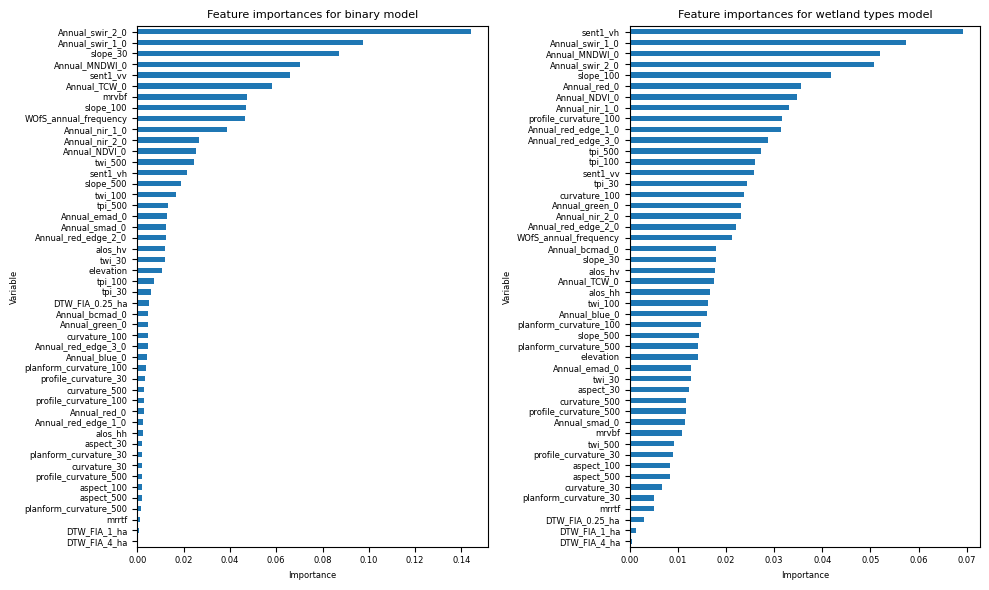

In [12]:
# Assuming you have trained RandomForestClassifier instances named 'binary_rf' and 'type_rf'
binary_feature_importances = binary_rf.feature_importances_

# List of variable names
variable_names = df_training_data.columns[2:]

# Calculate the figure width based on the number of variables
figure_width = max(5, len(variable_names) * 0.1)  # Minimum width of 8 inches

# If type_rf is available, create subplots for binary and type classifications
if 'type_rf' in locals():
    # Create subplots for binary classification and wetland type classification side by side
    fig, axs = plt.subplots(1, 2, figsize=(2 * figure_width, 6))

    # Plot feature importances for binary classification
    order_binary = np.argsort(binary_feature_importances)[::-1]
    order_binary = order_binary[::-1]  # Reverse order to display most important variables at the top
    axs[0].barh(y=variable_names[order_binary], width=binary_feature_importances[order_binary], height=0.5, align='center')
    axs[0].set_title('Feature importances for binary model', fontsize=8)
    axs[0].set_ylabel('Variable', fontsize=6)
    axs[0].tick_params(axis='both', which='major', labelsize=6)
    axs[0].set_xlabel('Importance', fontsize=6)
    axs[0].set_ylim(-0.5, len(variable_names) - 0.5)

    type_feature_importances = type_rf.feature_importances_
    # Plot feature importances for wetland type classification
    order_type = np.argsort(type_feature_importances)[::-1]
    order_type = order_type[::-1]  # Reverse order to display most important variables at the top
    axs[1].barh(y=variable_names[order_type], width=type_feature_importances[order_type], height=0.5, align='center')
    axs[1].set_title('Feature importances for wetland types model', fontsize=8)
    axs[1].set_ylabel('Variable', fontsize=6)
    axs[1].tick_params(axis='both', which='major', labelsize=6)
    axs[1].set_xlabel('Importance', fontsize=6)
    axs[1].set_ylim(-0.5, len(variable_names) - 0.5)

    plt.tight_layout()  # Automatically adjust the layout
    plt.show()
else:
    # If type_rf is not available, plot only the feature importances for binary classification
    plt.figure(figsize=(figure_width, 6))
    order_binary = np.argsort(binary_feature_importances)[::-1]
    order_binary = order_binary[::-1]  # Reverse order to display most important variables at the top
    plt.barh(y=variable_names[order_binary], width=binary_feature_importances[order_binary], height=0.5, align='center')
    plt.title('Feature importances for binary model', fontsize=8)
    plt.ylabel('Variable', fontsize=6)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.xlabel('Importance', fontsize=6)
    plt.ylim(-0.5, len(variable_names) - 0.5)
    plt.tight_layout()  # Automatically adjust the layout
    plt.show()


## Accuracy assessment

Finally we use a 5-fold cross validation to estimate the performance of the model. While the cross validation evaluates the predictive power of our model on unseen data, the result may not generalize for input data that have distinct spectral and temporal signatures to the training dataset. 

We will inspect four performance metrics:

* Overall accuracy
* Precision for each class - fraction of positive predictions that are correct. $precision = N_{True Positive}/(N_{True Positive} + N_{False Positive})$. The best value is 1 and the worst value is 0.
* Recall for each class - ability of the classifier to find all the positive samples. $recall = N_{True Positive}/(N_{True Positive} + N_{False Negative})$. The best value is 1 and the worst value is 0.
* F1 macro - averaged F1 scores for all classes. For each class, $F1 = 2*(precision*recall)/(precision+recall)$
* Plot confusion matrix - The confusion matrix compares all predictions against the labels and allow us to see what types of prediction errors the model is making. 


Binary Classification Evaluation:
Overall accuracy from cross-validation (Binary):  0.9657083236726176
Precision for each class (Binary): 
 {'Non-wetland': 0.964, 'Wetland': 0.967}
Recall for each class (Binary): 
 {'Non-wetland': 0.972, 'Wetland': 0.958}
F1_macro from cross-validation scores (Binary):  0.9654918848395504
Confusion matrix (Binary):



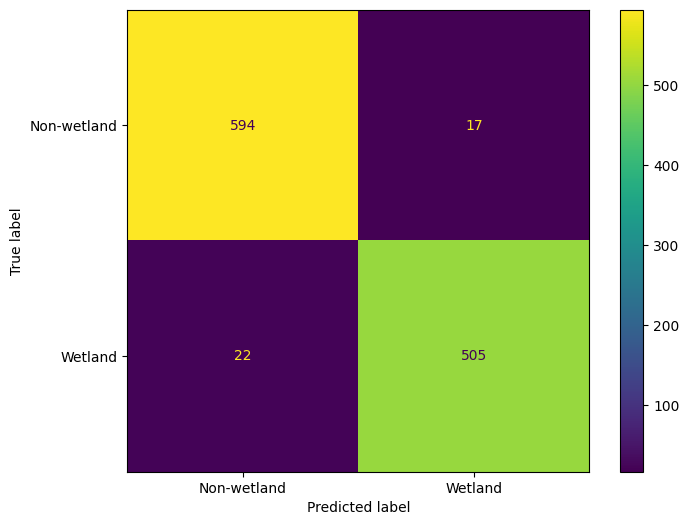


Wetland Type Classification Evaluation:
Overall accuracy from cross-validation (Wetland Type):  0.8368194070080863
Precision for each class (Wetland Type): 
 {'Dam': 0.687, 'Lake': 0.972, 'Open water': 0.78, 'Marsh': 0.808, 'Large river': 0.847}
Recall for each class (Wetland Type): 
 {'Dam': 0.648, 'Lake': 0.904, 'Open water': 0.793, 'Marsh': 0.902, 'Large river': 0.847}
F1_macro from cross-validation scores (Wetland Type):  0.8178903140281799
Confusion matrix (Wetland Type):



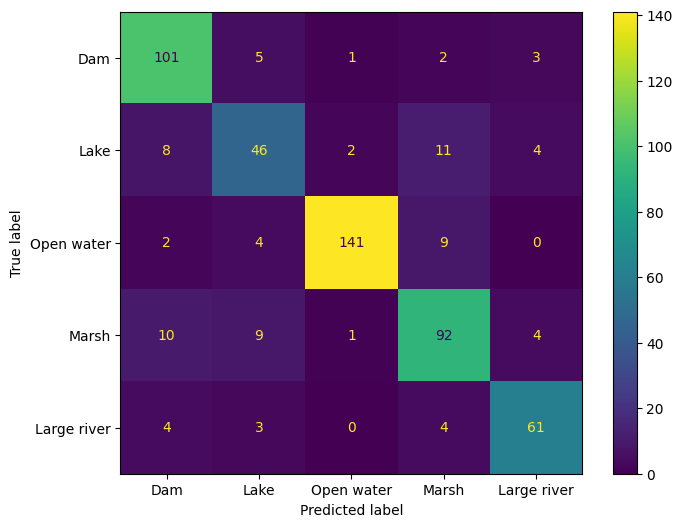

In [13]:
# Import the class label dictionary for wetland types
with open(f'data/{prefix}_labels_dict.json', 'r') as json_file:
    labels_dict_type = json.load(json_file)
    
# Remove the non-wetland class from the dictionary
if 0 in labels_dict_type.values():
    del labels_dict_type['Non-wetland']    

# Create a new label dictionary for binary classification
labels_dict_binary = {'Non-wetland': 0, 'Wetland': 1}

# Stratified k-fold splitting
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

# Binary classification evaluation
print("Binary Classification Evaluation:")
overall_acc_binary = model_selection.cross_val_score(binary_rf, X, y_binary, cv=skf, scoring='accuracy')
print('Overall accuracy from cross-validation (Binary): ', np.mean(overall_acc_binary))

predictions_binary = model_selection.cross_val_predict(binary_rf, X, y_binary, cv=skf)
precision_binary = precision_score(y_binary, predictions_binary, labels=list(labels_dict_binary.values()), average=None)
print('Precision for each class (Binary): \n', dict(zip(list(labels_dict_binary.keys()), np.around(precision_binary, 3))))

recall_binary = recall_score(y_binary, predictions_binary, labels=list(labels_dict_binary.values()), average=None)
print('Recall for each class (Binary): \n', dict(zip(list(labels_dict_binary.keys()), np.around(recall_binary, 3))))

f1_macro_binary = model_selection.cross_val_score(binary_rf, X, y_binary, cv=skf, scoring='f1_macro')
print('F1_macro from cross-validation scores (Binary): ', np.mean(f1_macro_binary))

cm_binary = confusion_matrix(y_binary, predictions_binary)
disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=list(labels_dict_binary.keys()))
print('Confusion matrix (Binary):\n')
fig_binary, ax_binary = plt.subplots(figsize=(8, 6))
disp_binary.plot(ax=ax_binary)
plt.show()


# Define the file paths for saving the feature names
binary_features_path = f"results/{prefix}_binary_model_features.json"
# Create dictionaries to store the feature names
binary_features_dict = {}
# Store binary model feature names
binary_features_dict["features"] = list(variable_names)
# Save the binary model feature names to a JSON file
with open(binary_features_path, "w") as binary_file:
    json.dump(binary_features_dict, binary_file, indent=4)

# Save the binary classification model
dump(binary_rf, f'results/{prefix}_Binary_RF_model.joblib')

# Wetland type classification evaluation if type_rf exists
if 'type_rf' in locals():
    print("\nWetland Type Classification Evaluation:")
    overall_acc_type = model_selection.cross_val_score(type_rf, X_wetland, y_wetland_type, cv=skf, scoring='accuracy')
    print('Overall accuracy from cross-validation (Wetland Type): ', np.mean(overall_acc_type))

    predictions_type = model_selection.cross_val_predict(type_rf, X_wetland, y_wetland_type, cv=skf)
    precision_type = precision_score(y_wetland_type, predictions_type, labels=list(labels_dict_type.values()), average=None)
    print('Precision for each class (Wetland Type): \n', dict(zip(list(labels_dict_type.keys()), np.around(precision_type, 3))))

    recall_type = recall_score(y_wetland_type, predictions_type, labels=list(labels_dict_type.values()), average=None)
    print('Recall for each class (Wetland Type): \n', dict(zip(list(labels_dict_type.keys()), np.around(recall_type, 3))))

    f1_macro_type = model_selection.cross_val_score(type_rf, X_wetland, y_wetland_type, cv=skf, scoring='f1_macro')
    print('F1_macro from cross-validation scores (Wetland Type): ', np.mean(f1_macro_type))

    cm_type = confusion_matrix(y_wetland_type, predictions_type)
    disp_type = ConfusionMatrixDisplay(confusion_matrix=cm_type, display_labels=list(labels_dict_type.keys()))
    print('Confusion matrix (Wetland Type):\n')
    fig_type, ax_type = plt.subplots(figsize=(8, 6))
    disp_type.plot(ax=ax_type)
    plt.show()
    

    # Define the file paths for saving the feature names
    type_features_path = f"results/{prefix}_type_model_features.json"
    # Create dictionaries to store the feature names
    type_features_dict = {}
    # Store type model feature names
    type_features_dict["features"] = list(variable_names)
    # Save the type model feature names to a JSON file
    with open(type_features_path, "w") as type_file:
        json.dump(type_features_dict, type_file, indent=4)

    # Save the wetland type classification model
    dump(type_rf, f'results/{prefix}_Type_RF_model.joblib')


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 